# Deep Q-Networks (DQN)

#### Google Drive directory for project (Google Colab Specific)

Required if you need to save the model checkpoints in google drive. I also save the replay memory after every few episodes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import random
import sys
import psutil
from tqdm import tqdm
from collections import deque, namedtuple
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import gym
from gym import logger as gymlogger
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Environment, Constants and Model Parameters

In [3]:
env = gym.make("Breakout-v0").env

print(env.observation_space)
print(env.action_space)
print(env.get_action_meanings())

Box(210, 160, 3)
Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [0]:
# Constants
TEST_MODULES = False # Whether to run test cases for individual modules
INPUT_SHAPE = env.observation_space.shape # (210,160,3) For Atari Games
PREPROCESSED_STATE_SHAPE = (84,84)
NUM_ACTIONS = env.action_space.n

# Parameters
gamma = 0.99
replay_memory_size = 80_000
min_replay_memory_size = 30_000
target_update_every = 10_000
num_episodes = 20_000
max_steps = 10_000_000
epsilon_start = 1.0
epsilon_end = 0.1
num_steps_epsilon_decay = 500_000
batch_size = 32
repeat_action = 4
model_save_freq = 1500 # Episodes
exp_dir = "/content/gdrive/My Drive/Colab Files/dqn_breakout"

#### Preprocess Atari Image

In [0]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize(PREPROCESSED_STATE_SHAPE, interpolation=Image.CUBIC),
                    T.ToTensor()])

def take_step_and_preprocess(env, action=None, repeat_action=4):
    """
    Takes the action or resets the environment if action = None
    Converts raw atari state from (210 x 160 x 3) -> (84 x 84)

    Args:
        repeat_action: How many steps to repeat the same action for
    """
    total_reward = 0
    done = False
    info = ''

    if action == None:
        screen = env.reset()
    else:
        cur_screen = env._get_obs()
        for i in range(repeat_action):
            next_screen, reward, done, info = env.step(action)
            total_reward += reward
            screen = np.maximum(cur_screen, next_screen)
            cur_screen = next_screen
            if done: break
    state = screen.transpose((2, 0, 1))
    state = state[:, 50:200, 5:155] # For Breakout
    state = np.ascontiguousarray(state, dtype=np.float32) / 255
    state = torch.from_numpy(state)
    state = resize(state)
    return state.to(device), total_reward, done, info

In [0]:
def test_preprocessing():
    preprocessed_image, _, _, _ = take_step_and_preprocess(env)
    assert preprocessed_image.shape==(1,84,84), "Preprocessed image not of desired size"
    print("Test: OK")

if TEST_MODULES: test_preprocessing()

#### Estimator Network
- This network is used by both online network and target network
- Both networks have different weights

In [0]:
class EstimatorNetwork(nn.Module):
    """
    Neural network used by online network and target network 
    """
    def __init__(self, env):
        super(EstimatorNetwork, self).__init__()
        self.env = env
        num_actions = env.action_space.n
        self.model = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
    
    def forward(self, states):
        return self.model(states)

In [0]:
# Test that the network actually learns
def test_estimator_network():
    estimator = EstimatorNetwork(env).to(device)
    observation, _, _, _ = take_step_and_preprocess(env)
    observations = torch.cat((observation, observation), 0)
    observations = torch.stack([observations] * 4, axis=1)

    y = torch.tensor([[10.0,10.0,10.0,10.0],[10.0,10.0,10.0,10.0]], device=device)
    optimizer = torch.optim.Adam(estimator.parameters(), lr=0.1)
    for i in range(200):
        predictions = estimator(observations)
        loss = F.smooth_l1_loss(predictions, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    new_preds = estimator(observations)
    assert max(new_preds[0]) < 11 and min(new_preds[0]) > 9, "Test failed for update"
    assert max(new_preds[1]) < 11 and min(new_preds[1]) > 9, "Test failed for update"
    print("Test2: OK")

if TEST_MODULES: test_estimator_network()

#### DQN Agent

In [0]:
def get_epsilon_greedy_policy(estimator):
    """
    Make an epsilon-greedy policy from given Q-values
    Returns:
        policy: epsilon-greedy policy which takes random action with
                probability epsilon/num_actions, otherwise takes
                greedy action
    """
    def policy(state, epsilon):
        with torch.no_grad():
            q_values = estimator(state)
        num_actions = q_values.size(1)
        greedy_action = torch.argmax(q_values).item()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

In [0]:
class DQNAgent:
    def __init__(self, env, replay_memory_size, exp_dir):
        """
        Initialize the deep Q-learning agent. Main components of DQN include
        - two estimator networks
            1. Online network
            2. Target network
        - replay memory

        Args:
            replay_memory_size: Size of replay memory
            exp_dir: Experiemnt directory
        """

        # DQN components
        self.env = env
        self.online_network = EstimatorNetwork(env).to(device)
        self.target_network = EstimatorNetwork(env).to(device)
        self.replay_memory = deque(maxlen=replay_memory_size)
        self.copy_network_weights()

        # Optimizer to be used for training
        self.optimizer = torch.optim.RMSprop(self.online_network.parameters(), lr=0.00025, alpha=0.99, eps=1e-06)
        self.loss = torch.nn.MSELoss()
        self.exp_dir = exp_dir

    def copy_network_weights(self):
        self.target_network.load_state_dict(self.online_network.state_dict())

    def create_checkpoint(self, episode, stats):
        model_dir = os.path.join(exp_dir, "models")
        model_filename = os.path.join(model_dir, "model_{}.pt".format(episode))
        optimizer_filename = os.path.join(model_dir, "optimizer_{}.pt".format(episode))
        replay_filename = os.path.join(exp_dir, "replay_{}.pt".format(episode))
        stats_filename = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        try:
            torch.save(self.online_network.state_dict(), model_filename)
            torch.save(self.optimizer.state_dict(), optimizer_filename)
            torch.save(self.replay_memory, replay_filename)
            torch.save(stats, stats_filename)
            print("\nCheckpoint created for episode {}".format(episode))
        except:
            print ("\nCouldn't create checkpoint.")

    def load_checkpoint(self, episode):
        model_dir = os.path.join(exp_dir, "models")
        model_filename = os.path.join(model_dir, "model_{}.pt".format(episode))
        optimizer_filename = os.path.join(model_dir, "optimizer_{}.pt".format(episode))
        replay_filename = os.path.join(exp_dir, "replay_{}.pt".format(episode))
        stats_filename = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        try:
            self.online_network.load_state_dict(torch.load(model_filename, map_location=device))
            self.optimizer.load_state_dict(torch.load(optimizer_filename, map_location=device))
            self.replay_memory = torch.load(replay_filename, map_location=device)
            stats = torch.load(stats_filename, map_location=device)
            print("\nCheckpoint loaded for episode {}".format(episode))
        except:
            print ("\nCouldn't load checkpoint.")
            return 0
        self.copy_network_weights()
        return stats['total_steps']+1

    def train(self, gamma, min_replay_memory_size, target_update_every, num_episodes, max_steps,
              epsilon_start, num_steps_epsilon_decay, epsilon_end, batch_size, repeat_action, model_save_freq,
              load_from_checkpoint=False, last_episode=0):
        """
        Trains the DQN Agent

        Args:
            gamma: Discount Factor
            min_replay_memory_size: Minimum size of replay memory
            target_update_every: Copy weights from online network to target
                                 network after this many (time) steps
            num_episodes: Maximum number of episodes to train
            max_steps: Maximum number of times to train
            epsilon_start: Initial epsilon for epsilon-greedy policy
            epsilon_end: Mininum value epsilon can go to
            num_steps_epsilon_decay: Use epsilon decay for this many steps
            batch_size: Batch size to sample from replay memory
            repeat_action: Number of frames to repeat the last action
            model_save_freq: Save the model and replay memory to disk after this many episodes
            load_from_checkpoint: Whether to load model from checkpoint
            last_episode: Number of episodes the agent was already trained on.
                          Used for checkpoint name and initialize model weights
        """

        Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
        
        policy = get_epsilon_greedy_policy(self.target_network)
        epsilons = np.linspace(epsilon_start, epsilon_end, num_steps_epsilon_decay)
        total_steps = 0

        if load_from_checkpoint:
            total_steps = self.load_checkpoint(last_episode)

        stats = {'starting_episode': last_episode+1,
                 'epsilon': [],
                 'training_losses': [],
                 'episode_lengths': [],
                 'episode_rewards': [],
                 'total_steps': total_steps}

        replay_memory_populated = False
        
        if len(self.replay_memory) >= min_replay_memory_size:
            replay_memory_populated = True

        episode_reward = 0
        episode_length = 0
        recent_rewards = deque(maxlen=100)
        all_episodes = tqdm(range(last_episode + 1, num_episodes + 1), unit='episode', position=0, leave=True)
        for episode_num in all_episodes:
            recent_mean_score = np.round(np.mean(recent_rewards), 2) if len(recent_rewards) > 0 else 0.0
            all_episodes.set_description("Training Steps: {}, Episode Score: {}, Recent Avg Score: {}"\
                                         .format(total_steps, episode_reward, recent_mean_score))
            total_loss = 0
            episode_reward = 0
            episode_length = 0

            state, _, _, _ = take_step_and_preprocess(self.env)
            state = torch.stack([state] * 4, axis=1)

            while True: # Until eipsode finishes
                epsilon = epsilons[min(total_steps, num_steps_epsilon_decay-1)]

                # Choose and take action based on above policy
                action_probs = policy(state, epsilon)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

                # Take one step into the environment (One hack to speed up training involved)
                lives_before = self.env.ale.lives()
                next_state, reward, done, info = take_step_and_preprocess(self.env, action, repeat_action)
                lives_after = self.env.ale.lives()
                # Losing life terminates the episode
                replay_done = done if lives_before <= lives_after else True
                next_state = next_state.unsqueeze(1)
                next_state = torch.cat((state[:,1:,:,:], next_state), 1)
                reward = torch.tensor([reward], device=device)
                action = torch.tensor([action], device=device)
                replay_done = torch.tensor([replay_done], device=device)

                # Update replay memory
                self.replay_memory.append((state,action,reward,next_state,replay_done))
                state = next_state

                # Move onto next step if replay memory not filled with minimum experience
                # No training happens in this case
                if len(self.replay_memory) < min_replay_memory_size:
                    if done: break
                    continue

                # Training starts now
                if not replay_memory_populated:
                    print("\nReplay memory filled with minimum experience.")
                    replay_memory_populated = True
                    break

                total_steps += 1

                # Copy weights from online network to target network after every few steps
                if total_steps % target_update_every == 0:
                    self.copy_network_weights()

                # Sample a random batch of experiences from replay memory
                experience_sample = random.sample(self.replay_memory, batch_size)
                batch = Transition(*zip(*experience_sample))
                states_batch = torch.cat(batch.state)
                actions_batch = torch.cat(batch.action)
                rewards_batch = torch.cat(batch.reward)
                next_states_batch = torch.cat(batch.next_state)
                done_batch = torch.cat(batch.done)

                # Get q_values of greedy targets for this batch
                with torch.no_grad():
                    next_q_values = self.target_network(next_states_batch)
                targets_batch = rewards_batch + (~done_batch) * gamma * torch.max(next_q_values, 1)[0]

                batch_size = states_batch.size(0)
                predictions = self.online_network(states_batch)
                
                # Get the q_values of only current actions taken from states
                action_indices = torch.arange(batch_size, device=device) * predictions.size(1) + actions_batch
                action_predictions = torch.gather(predictions.view(-1), 0, action_indices)
                
                # Compute loss and optimize model
                loss = self.loss(targets_batch, action_predictions)
                self.optimizer.zero_grad()
                loss.backward()
                for param in self.online_network.parameters():
                    param.grad.data.clamp_(-1, 1)
                self.optimizer.step()

                # Update Stats
                total_loss += loss.item()
                episode_reward += reward.item()
                episode_length += 1

                if done: break

            if replay_memory_populated and episode_length > 0:
                # Update stats
                stats['epsilon'].append(epsilon)
                stats['training_losses'].append(total_loss / episode_length)
                stats['episode_rewards'].append(episode_reward)
                stats['episode_lengths'].append(episode_length)
                stats['total_steps'] = total_steps
                recent_rewards.append(episode_reward)

            if episode_num % model_save_freq == 0 or total_steps >= max_steps or episode_num == num_episodes:
                self.create_checkpoint(episode_num, stats)
            if total_steps >= max_steps:
                break

        print("\nFinished")
        return stats

#### Start training the agent
Now, it's time to actually run the agent and see how it performs.

In [0]:
agent = DQNAgent(env, replay_memory_size, exp_dir)

stats = agent.train(gamma = gamma,
                    min_replay_memory_size = min_replay_memory_size,
                    target_update_every = target_update_every,
                    num_episodes = num_episodes,
                    max_steps = max_steps,
                    epsilon_start = epsilon_start,
                    num_steps_epsilon_decay = num_steps_epsilon_decay,
                    epsilon_end = epsilon_end,
                    batch_size = batch_size,
                    repeat_action = repeat_action,
                    model_save_freq = model_save_freq,
                    load_from_checkpoint = True,
                    last_episode = 7500)

Training Steps: 691869, Episode Score: 0, Recent Avg Score: 0.0:   0%|          | 0/14000 [00:00<?, ?episode/s]


Checkpoint loaded for episode 6000


Training Steps: 995991, Episode Score: 19.0, Recent Avg Score: 12.78:  11%|█         | 1500/14000 [1:26:50<234:26:16, 67.52s/episode]


Checkpoint created for episode 7500


Training Steps: 1202248, Episode Score: 8.0, Recent Avg Score: 12.39:  18%|█▊        | 2485/14000 [2:23:33<9:10:51,  2.87s/episode]

## Let's check the training results

### Training Losses and Rewards

In [0]:
all_losses = []
all_rewards = []
all_epsilons = []
load_stats_from_file = True # Set this to true if want to load training statistics from files

if load_stats_from_file:
    last_episodes = [6000, 7500] # Update this list with every new run end episode
    for episode in last_episodes:
        stats_file = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        stats = torch.load(stats_file)
        all_losses += stats["training_losses"]
        all_rewards += stats["episode_rewards"]
else:
    all_losses += stats["training_losses"]
    all_rewards += stats["episode_rewards"]

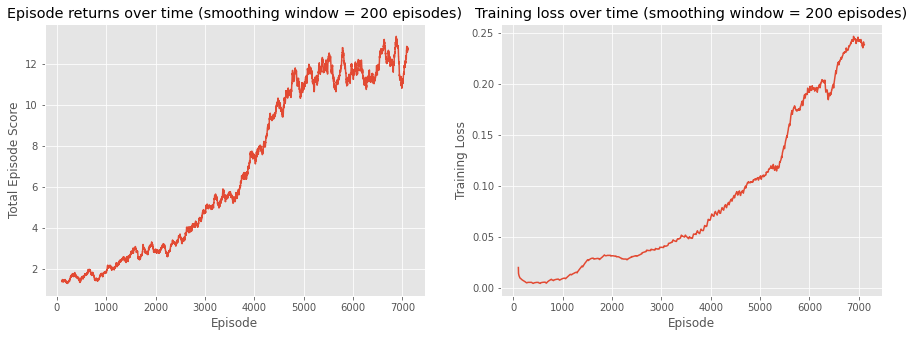

In [12]:
def plot_stats(losses, rewards):
    losses = pd.Series(all_losses).rolling(100).mean()
    rewards = pd.Series(all_rewards).rolling(100).mean()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(rewards)
    ax1.set_title("Episode returns over time (smoothing window = 200 episodes)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total Episode Score")

    ax2.plot(losses)
    ax2.set_title("Training loss over time (smoothing window = 200 episodes)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Training Loss")
    plt.show()

plot_stats(all_losses, all_rewards)

### Let's see the agent's behaviour

In [0]:
!apt-get install -y xvfb python-opengl x11-utils ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
from gym.wrappers import Monitor
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display_params = display.start()

In [0]:
# This function to render gym environment in colab is taken from
# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

class MonitorNew(Monitor):
    def __init__(self, env, directory, force=False):
        self.env = env
        super(MonitorNew, self).__init__(env, directory, force=force)

    def _get_obs(self):
        return self.env._get_obs()

def wrap_env(env):
    env = MonitorNew(env, './video', force=True)
    return env

In [0]:
def show_episode(gym_env, policy, epsilon):
    env = wrap_env(gym_env)
    env.reset()
    state, _, _, _ = take_step_and_preprocess(gym_env)
    state = torch.stack([state] * 4, axis=1)
    final_score = 0
    t = 0
    while True:
        env.render()
        action_probs = policy(state, epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, info = take_step_and_preprocess(env, action, repeat_action=4)
        next_state = next_state.unsqueeze(1)
        next_state = torch.cat((state[:,1:,:,:], next_state), 1)
        final_score += reward
        state = next_state
        t += 1
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("Final Score: {}".format(int(final_score)))
            break
    env.close()
    show_video()

#### Run the Agent

In [23]:
checkpoint_episode = 7500
checkpoint_name = os.path.join(os.path.join(exp_dir, "models"), "model_{}.pt".format(checkpoint_episode))

online_network = EstimatorNetwork(env).to(device)
online_network.load_state_dict(torch.load(checkpoint_name, map_location=torch.device(device)))
policy = get_epsilon_greedy_policy(online_network)
show_episode(env, policy, epsilon=0.01)

Episode finished after 234 timesteps
Final Score: 24


### Conclusion
As mentioned in the DQN paper, the effect of replay memory is clear from the results. Since I was only able to use a small replay memory of size 80,000 the model was only able to achieve sub-optimal results. The DQN agent is only able to reach the average training score of 12-15 after training for 6000 episodes (more than 2 million frames). At the time of evaluation, due to greedy policy the agent is able to achieve the score of more than 20.